In [4]:
import numpy as np
import qutip as qt
from qutip import *
import matplotlib.pyplot as plt
import sympy as sp

NOTE TO SELF: Squeezed cat state i qutip, test nogle gates fra Olga's paper (nok også smart at gøre i qutip), og så var der noget reference paper fra Jonas, test GKP gates (fra det originale GKP paper?) Ellers bliv god til qutip    

In [185]:
hbar = 1
x = np.linspace(-8,8, 300)
p = np.linspace(-8,8, 300)

def a(N):
    """Create the annihilation operator for a harmonic oscillator."""
    return qt.destroy(N)

class sq_cat_state:
    def __init__(self, N, k=1, alpha=1, r = 0):
        self.N = N
        self.k = k
        self.alpha = alpha
        self.r = r

    def state(self):
        S = qt.squeeze(self.N, self.r)
        return S * (qt.coherent(self.N, self.alpha) + (-1)**self.k * qt.coherent(self.N, -self.alpha)).unit()

    

def bs(N, theta, state1, state2):
    a1 = destroy(N)
    a1dag = a1.dag()
    a2 = destroy(N)
    a2dag = a2.dag()

 #   T = 1/eta

 #   theta = np.arccos(np.sqrt(T))

    x1 = (a1 + a1dag)*1/np.sqrt(2)
    p1 = 1j * (a1dag - a1)*1/np.sqrt(2)
    x2 = (a2 + a2dag)*1/np.sqrt(2)
    p2 = 1j * (a2dag - a2)*1/np.sqrt(2)

    U = 1j * theta * (tensor(p1, x2) - tensor(x1, p2)) 
    # Create the joint state
    joint_state = qt.tensor(state1, state2)
    
    # Apply the beam splitter
    return U * joint_state



In [186]:
from tqdm.notebook import tqdm  # For Jupyter notebooks
# from tqdm import tqdm  # For non-notebook environments

def breeding(N, n, alphas=None, rs=None, ks=None, p_measured=0):
    """
    Args:
        N (int): Hilbert space dimension.
        n (int): Number of input states (breeding steps = n-1).
        alphas (list): Optional list of n coherent state amplitudes. Defaults to [1, ..., 1].
        rs (list): Optional list of n squeezing parameters. Defaults to [1, ..., 1].
        ks (list): Optional list of n parity values (0=even, 1=odd). Defaults to [1, ..., 1].
        p_measured (float): Momentum measurement result. Default 0.
        
    Returns:
        final_state (qt.Qobj): Conditional state of the last mode.
        measurement_probs (list): Probabilities of p_measured outcomes.
    """
    # Set defaults
    alphas = alphas if alphas is not None else [1.0] * n
    rs = rs if rs is not None else [1.0] * n
    ks = ks if ks is not None else [1] * n
    
    # Validate inputs
    if len(alphas) != n or len(rs) != n or len(ks) != n:
        raise ValueError(f"Parameters must be lists of length {n}")
    
    # Initialize states
    states = [sq_cat_state(N, ks[i], alphas[i], rs[i]) for i in range(n)]
    
    current_state = states[0].state()
    display(current_state)
    measurement_probs = []
    
    # Progress bar for breeding steps
    for i in tqdm(range(n-1), desc="Breeding Progress", unit="step"):
        theta_i = np.arccos(np.sqrt(1/(i+2)))  # Reflectivity = 1/(i+2)
        output_state = bs(theta_i, states[i], states[i+1])
        # Measure mode 2 in p=p_measured
        p_state = qt.momentum(N, p_measured)
        projector = qt.tensor(qt.qeye(N), p_state.proj())
        print("projector")
        display(projector)
        unnormalized = projector @ output_state
        print("Unnormalized")
        display(unnormalized)
        prob = unnormalized.norm()**2
        measurement_probs.append(min(prob, 1.0))
        
        if prob < 1e-8:
            print(f"Warning: Near-zero probability at step {i}")
            return None, measurement_probs
        
        current_state = unnormalized.ptrace(0).unit()
        print("Current State")
        display(current_state)
    
    return current_state, measurement_probs

In [187]:
from tqdm.notebook import tqdm  # For Jupyter notebooks
# from tqdm import tqdm  # For non-notebook environments

def breeding(N, n, alphas=None, rs=None, ks=None, p_measured=0):
    """
    Args:
        N (int): Hilbert space dimension.
        n (int): Number of input states (breeding steps = n-1).
        alphas (list): Optional list of n coherent state amplitudes. Defaults to [1, ..., 1].
        rs (list): Optional list of n squeezing parameters. Defaults to [1, ..., 1].
        ks (list): Optional list of n parity values (0=even, 1=odd). Defaults to [1, ..., 1].
        p_measured (float): Momentum measurement result. Default 0.
        
    Returns:
        final_state (qt.Qobj): Conditional state of the last mode.
        measurement_probs (list): Probabilities of p_measured outcomes.
    """
    # Set defaults
    alphas = alphas if alphas is not None else [1.0] * n
    rs = rs if rs is not None else [1.0] * n
    ks = ks if ks is not None else [1] * n
    
    # Validate inputs
    if len(alphas) != n or len(rs) != n or len(ks) != n:
        raise ValueError(f"Parameters must be lists of length {n}")
    
    # Initialize states
    states = [sq_cat_state(N, ks[i], alphas[i], rs[i]) for i in range(n)]
    
    current_state = states[0].state()
    print("start state")
    display(current_state)
    measurement_probs = []
    
    # Progress bar for breeding steps
    for i in tqdm(range(n-1), desc="Breeding Progress", unit="step"):
        theta_i = np.arccos(np.sqrt(1/(i+2)))  # Reflectivity = 1/(i+2)
        output_state = bs(N, theta_i, current_state, states[i+1])
        
        # Measure mode 2 in p=p_measured
        x = np.linspace(-np.pi, np.pi, N)  # Position space grid
        px = np.exp(1j * p_measured * x)  # Plane wave for momentum p_measured
        p_ket = qt.Qobj(px, dims=[[N], [1]])  # Momentum eigenstate as a ket
        p_ket = p_ket.unit()  # Normalize the ket
        print("p_ket")
        display(p_ket)
        
        proj_op = qt.tensor(qt.qeye(N), p_ket * p_ket.dag())  # Projector on mode 2
        display(p_ket * p_ket.dag())
        print("proj_op")
        display(proj_op)
        collapsed_state = proj_op * output_state  # Still two-mode
        
        prob = collapsed_state.norm()**2
        measurement_probs.append(min(prob, 1.0))
        
        if prob < 1e-8:
            print(f"Warning: Near-zero probability at step {i}")
            return None, measurement_probs
        
        # Keep only the first mode as a ket
        current_state = collapsed_state.ptrace(0).unit()
        print("Output current state")
        display(current_state)
    
    return current_state, measurement_probs


In [188]:
# Parameters
N = 30
alphas = [1.0, 1.0, 1.0]    # Three coherent states
rs = [0.5, 0.5, 0.5]
ks = [1,1,1]    # Parities

# Run breeding protocol
final_state, probs = breeding(N, 3, alphas, rs)

# Results
print(f"Final state norm: {final_state.norm()}")
print(f"Measurement probabilities: {probs}")
# OOOOBS    Det tager lang tid (længere end udregningen) at udregne wigner functionen, +15min for N=30, n=3, grid =300
#WIG = qt.wigner(final_state, x, p) # Visualize the final state #

start state


Quantum object: dims=[[30], [1]], shape=(30, 1), type='ket', dtype=Dense
Qobj data =
[[ 0.00000000e+00]
 [ 9.70607745e-01]
 [ 0.00000000e+00]
 [-2.37711228e-01]
 [ 0.00000000e+00]
 [ 1.66109507e-02]
 [ 0.00000000e+00]
 [ 2.40169885e-02]
 [ 0.00000000e+00]
 [-2.01031639e-02]
 [ 0.00000000e+00]
 [ 1.11726960e-02]
 [ 0.00000000e+00]
 [-5.19922260e-03]
 [ 0.00000000e+00]
 [ 2.13796592e-03]
 [ 0.00000000e+00]
 [-7.79536613e-04]
 [ 0.00000000e+00]
 [ 2.41461526e-04]
 [ 0.00000000e+00]
 [-5.28359165e-05]
 [ 0.00000000e+00]
 [-2.05808996e-06]
 [ 0.00000000e+00]
 [ 1.24527333e-05]
 [ 0.00000000e+00]
 [-9.32448900e-06]
 [ 0.00000000e+00]
 [ 8.00622261e-06]]

Breeding Progress:   0%|          | 0/2 [00:00<?, ?step/s]

TypeError: requires Qobj or QobjEvo operands

In [160]:
Px = np.trapezoid(WIG, p, axis=0)  
Pp = np.trapezoid(WIG, x, axis=1)
vmin = np.min(WIG)
vmax = np.max(WIG)


<>:15: SyntaxWarning: invalid escape sequence '\D'
<>:15: SyntaxWarning: invalid escape sequence '\D'
C:\Users\alexa\AppData\Local\Temp\ipykernel_3580\2427014225.py:15: SyntaxWarning: invalid escape sequence '\D'
  axs[1,0].set_title(" $\Delta_x={}$, $\Delta_p=\Delta_x$, N = {}".format(np.exp(-rs[0]), N))


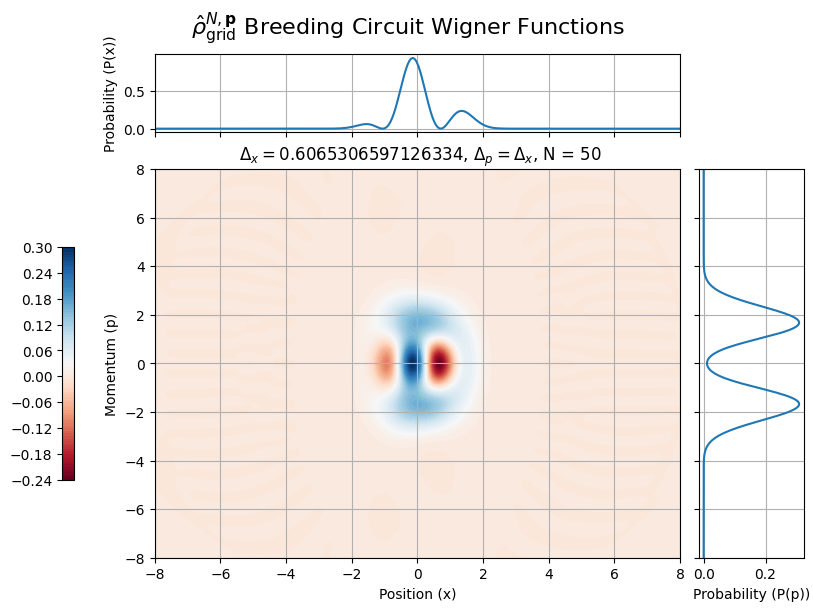

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6), constrained_layout=True, gridspec_kw={"height_ratios": [0.2, 1], "width_ratios": [1, 0.2]}, sharex = "col", sharey = "row")

plt.suptitle(r"$\hat{\rho}_{\mathrm{grid}}^{N,\bf{p}}$ Breeding Circuit Wigner Functions", fontsize=16)

axs[0, 0].plot(x,Px)
axs[0, 0].set_ylabel("Probability (P(x))")
axs[0,0].grid()

#axs[0, 0].set_title("Top-left")

axs[0, 1].axis('off')  # disables axes for this cell

cf3 = axs[1,0].contourf(x, p, WIG, levels=100, cmap='RdBu', vmin=vmin, vmax=vmax)

axs[1,0].set_title(" $\Delta_x={}$, $\Delta_p=\Delta_x$, N = {}".format(np.exp(-rs[0]), N))
axs[1,0].set_xlabel("Position (x)")
axs[1,0].set_ylabel("Momentum (p)")
axs[1,0].grid()
fig.colorbar(cf3, ax=axs[1,0], location = 'left', shrink = 0.6)

axs[1, 1].plot(Pp,p)
axs[1, 1].set_xlabel("Probability (P(p))")
axs[1, 1].grid()
fig.savefig("breeding_wigner.jpg_0", dpi=300, format='png')